In [1]:
#!/usr/bin/env python
# coding: utf-8

# ### Tensorflow time series forecasting applied to driving cycle data
# Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Driving cycle dataset
df_ = pd.read_csv('data/nedc.csv', names=['t (s)', 'v (km/h)'], index_col='t (s)')

# Have it repeated
df_ = pd.concat([df_, df_[1:]], ignore_index=True)
df_.index.name = 't (s)'

# Normalize the data
# Use all the data for training (no split)
df_mean = df_.mean()
df_std = df_.std()
df = (df_ - df_mean) / df_std


# Class for data windowing
class WindowGenerator():
    # 1. Indexes and offsets
    def __init__(self, input_width, label_width, shift,
                 df=df, label_columns=None):
        # Store the raw data.
        self.df = df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

        # Store example batch of tf.data.Dataset
        self._example = None

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    # 2. Split into inputs/labels
    def split_window(self, features):
        # [batch_size, window_size, features]
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    # 3. Plot
    def plot(self, model=None, plot_col='v (km/h)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col] # Here we have only one input column.
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()
                  
        plt.xlabel('Time [s]')

    # 4. Create tf.data.Dataset
    # Convert pandas.DataFrame to tensorflow.data.Dataset
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.df)

    @property
    def example(self):
        result = next(iter(self.train))
#         result = getattr(self, '_example')
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


MAX_EPOCHS = 100


def compile_and_fit(model, window, patience=2):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                       patience=patience,
#                                                       mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.train)
#                         callbacks=[early_stopping])
    
    return history

### Multi-Step Prediction Models

#### LSTM-30-30-16-16

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause:

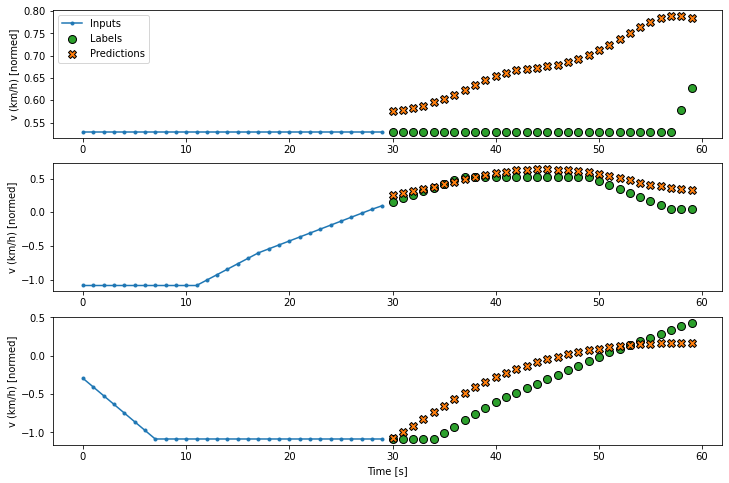

In [1]:
OUT_STEPS = 30
IN_STEPS = 30
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_performance = {'LSTM': multi_lstm_model.evaluate(multi_window.train)}

multi_window.plot(multi_lstm_model)
plt.show()

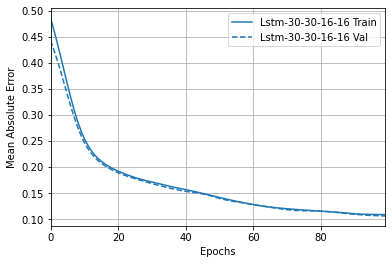

In [6]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

histories = {}
histories['LSTM-30-30-16-16'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

In [9]:
multi_lstm_model.save("models/LSTM/32-100/30-30-16-16")

INFO:tensorflow:Assets written to: models/LSTM/32-100/30-30-16-16\assets


In [11]:
new_data = np.array(df, dtype=np.float32)

ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=new_data,
    targets=None,
    sequence_length=IN_STEPS,
    sequence_stride=OUT_STEPS,
    shuffle=False,
    batch_size=32)

predictions = multi_lstm_model.predict(ds)
predictions = (predictions * df_std[0]) + df_mean[0]
predictions

array([[[ 4.42863464e-01],
        [ 9.07135010e-03],
        [-3.71662140e-01],
        ...,
        [ 2.05438213e+01],
        [ 2.35902901e+01],
        [ 2.65733204e+01]],

       [[ 2.33296814e+01],
        [ 2.60170212e+01],
        [ 2.83658180e+01],
        ...,
        [ 3.48634071e+01],
        [ 3.23971138e+01],
        [ 2.97997551e+01]],

       [[ 1.58443813e+01],
        [ 1.34697323e+01],
        [ 1.11041470e+01],
        ...,
        [ 3.55259132e+00],
        [ 4.50311470e+00],
        [ 5.55068207e+00]],

       ...,

       [[ 1.02291084e+02],
        [ 1.03219070e+02],
        [ 1.04098595e+02],
        ...,
        [ 1.20154678e+02],
        [ 1.19446167e+02],
        [ 1.18677017e+02]],

       [[ 1.10033234e+02],
        [ 1.08636406e+02],
        [ 1.06999130e+02],
        ...,
        [ 1.68565903e+01],
        [ 1.31319370e+01],
        [ 9.78987122e+00]],

       [[ 3.14027596e+00],
        [ 1.77031708e+00],
        [ 6.22249603e-01],
        ...,
        

In [14]:
def plot_orig(i, predictions):
    new_data = np.array(df_, dtype=np.float32)
    
    input_indices = np.arange((i-1)*OUT_STEPS, (i-1)*OUT_STEPS+IN_STEPS)
    label_indices = np.arange((i-1)*OUT_STEPS+IN_STEPS, i*OUT_STEPS+IN_STEPS)

    inputs = new_data[(i-1)*OUT_STEPS:(i-1)*OUT_STEPS+IN_STEPS, 0]
    labels = new_data[(i-1)*OUT_STEPS+IN_STEPS:i*OUT_STEPS+IN_STEPS, 0]

    plt.figure(figsize=(12, 3))
    plt.plot(input_indices, inputs,
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(label_indices, labels,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    plt.scatter(label_indices, predictions[i-1, :, 0],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    
    plt.legend()

    plt.xlabel('Time [s]')
    plt.ylabel('v (km/h) [normed]')

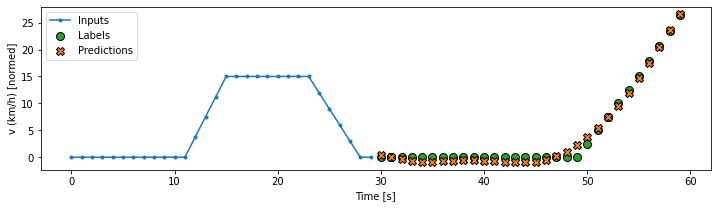

In [15]:
plot_orig(1, predictions)

In [16]:
predictions = predictions.flatten()
predictions.shape

(2340,)

In [45]:
predictions_df = pd.DataFrame(predictions, columns=['v (km/h)'])

dummy_df = pd.DataFrame([0]*IN_STEPS, columns=['v (km/h)'])
predictions_df = pd.concat([dummy_df, predictions_df], ignore_index=True)

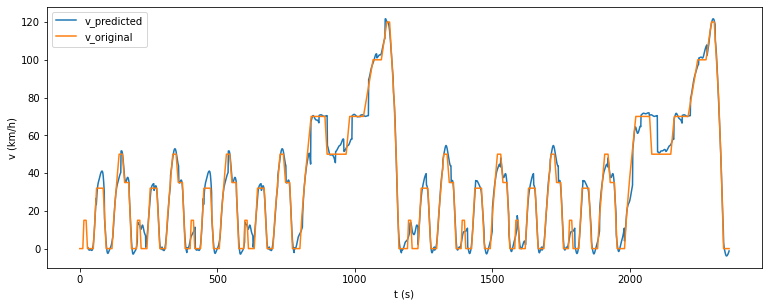

In [68]:
plt.rcParams["figure.figsize"] = (12.8, 4.8)
ax1 = predictions_df.loc[(predictions_df.index >= 30) & (predictions_df.index <= 2360)].plot()
ax2 = df_.plot(ax=ax1)
plt.legend(['v_predicted', 'v_original']);
plt.xlabel('t (s)')
plt.ylabel('v (km/h)')
plt.show()

#### Prepare to export to a csv file

In [72]:
predicted_df = pd.DataFrame(predictions, columns=['v (km/h)'])
predicted_df

,v (km/h)
0,0.442863
1,0.009071
2,-0.371662
3,-0.668594
4,-0.802181
...,...
2335,2.020521
2336,2.914810
2337,3.901024
2338,4.966202


In [73]:
predicted_df = pd.concat([df_[:IN_STEPS], predicted_df], ignore_index=True)
predicted_df.index.name = 'time'
predicted_df.columns = ['v']
predicted_df

,v
time,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
2365,2.020521
2366,2.914810
2367,3.901024


In [74]:
predicted_df = predicted_df[:2361]
predicted_df

,v
time,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
2356,-2.873913
2357,-2.513325
2358,-2.130859


In [75]:
# Set the lower limit value for the velocity to 0.
predicted_df = predicted_df.applymap(lambda x: 0 if x < 0 else x)
# Convert the unit to (m/s).
predicted_df = predicted_df.applymap(lambda x: x * 1000 / 3600)
predicted_df

,v
time,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2356,0.0
2357,0.0
2358,0.0


In [79]:
# np.savetxt('prediction_v.csv', predictions, delimiter=',', header='time,v', comments='')
predicted_df.to_csv('data/predicted/pv_lstm-30-30-16-16.csv')

#### LSTM-60-30-16-16

Epoch 1/100
71/71 [==============================] - 3s 43ms/step - loss: 0.7745 - mean_absolute_error: 0.7076 - val_loss: 0.4865 - val_mean_absolute_error: 0.5754
Epoch 2/100
71/71 [==============================] - 3s 35ms/step - loss: 0.4214 - mean_absolute_error: 0.5267 - val_loss: 0.3724 - val_mean_absolute_error: 0.4878
Epoch 3/100
71/71 [==============================] - 2s 35ms/step - loss: 0.3351 - mean_absolute_error: 0.4615 - val_loss: 0.2921 - val_mean_absolute_error: 0.4227
Epoch 4/100
71/71 [==============================] - 2s 35ms/step - loss: 0.2660 - mean_absolute_error: 0.4072 - val_loss: 0.2429 - val_mean_absolute_error: 0.3918
Epoch 5/100
71/71 [==============================] - 2s 34ms/step - loss: 0.2297 - mean_absolute_error: 0.3723 - val_loss: 0.2348 - val_mean_absolute_error: 0.3555
Epoch 6/100
71/71 [==============================] - 2s 34ms/step - loss: 0.1951 - mean_absolute_error: 0.3390 - val_loss: 0.1974 - val_mean_absolute_error: 0.3349
Epoch 7/100
71/7

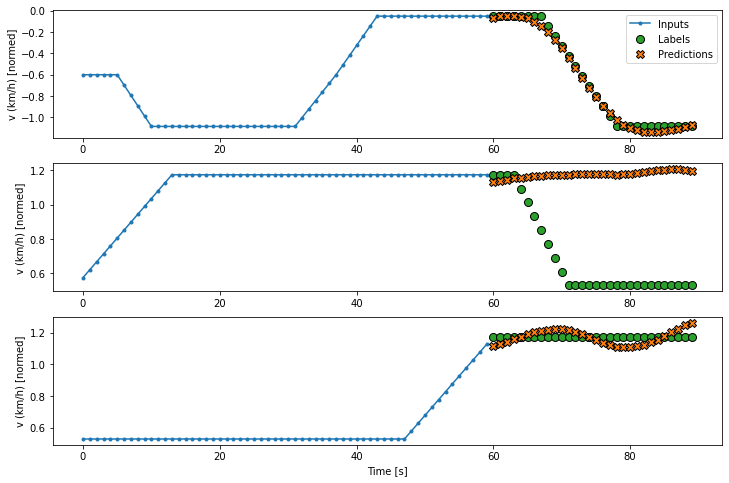

In [85]:
IN_STEPS = 60
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
lstm_60_30_16_16 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

history = compile_and_fit(lstm_60_30_16_16, multi_window)

multi_performance = {'LSTM-60-30-16-16': lstm_60_30_16_16.evaluate(multi_window.train)}

multi_window.plot(lstm_60_30_16_16)
plt.show()

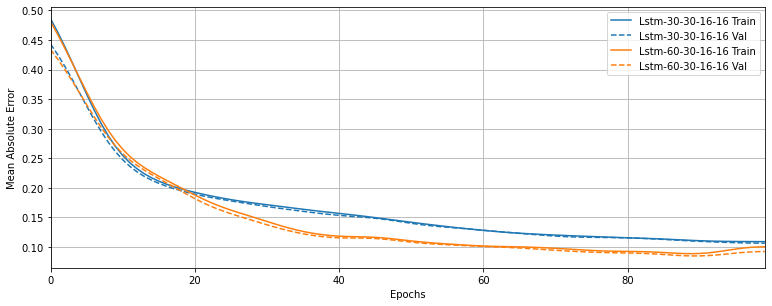

In [86]:
histories['LSTM-60-30-16-16'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

In [88]:
lstm_60_30_16_16.save("models/LSTM/32-100/60-30-16-16")

INFO:tensorflow:Assets written to: models/LSTM/32-100/60-30-16-16\assets


In [97]:
def plot_orig(i, predictions, in_steps, out_steps):
    new_data = np.array(df_, dtype=np.float32)
    
    input_indices = np.arange((i-1)*out_steps, (i-1)*out_steps+in_steps)
    label_indices = np.arange((i-1)*out_steps+in_steps, i*out_steps+in_steps)

    inputs = new_data[(i-1)*out_steps:(i-1)*out_steps+in_steps, 0]
    labels = new_data[(i-1)*out_steps+in_steps:i*out_steps+in_steps, 0]

    plt.figure(figsize=(12, 3))
    plt.plot(input_indices, inputs,
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(label_indices, labels,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    plt.scatter(label_indices, predictions[i-1, :, 0],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    
    plt.legend()

    plt.xlabel('Time [s]')
    plt.ylabel('v (km/h) [normed]')

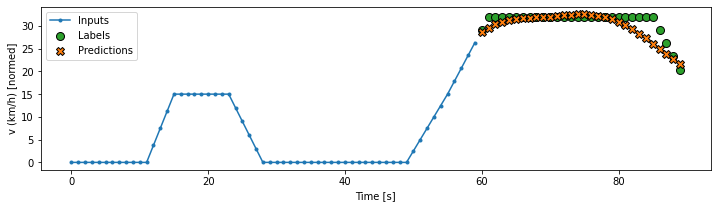

In [101]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=new_data,
    targets=None,
    sequence_length=IN_STEPS,
    sequence_stride=OUT_STEPS,
    shuffle=False,
    batch_size=32)
    
predictions = lstm_60_30_16_16.predict(ds)
predictions = (predictions * df_std[0]) + df_mean[0]
plot_orig(1, predictions, IN_STEPS, OUT_STEPS)

In [108]:
def postprocess_predictions(predictions, in_steps):
    predictions = predictions.flatten()

    predictions_df = pd.DataFrame(predictions, columns=['v (km/h)'])

#     predictions_df = pd.concat([df_[:in_steps], predicted_df], ignore_index=True)
    dummy_df = pd.DataFrame([0]*in_steps, columns=['v (km/h)'])
    predictions_df = pd.concat([dummy_df, predictions_df], ignore_index=True)
    
    return predictions_df

In [110]:
predictions_df = postprocess_predictions(predictions, IN_STEPS)
predictions_df

,v (km/h)
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
2365,1.444336
2366,2.841526
2367,4.338030
2368,5.875116


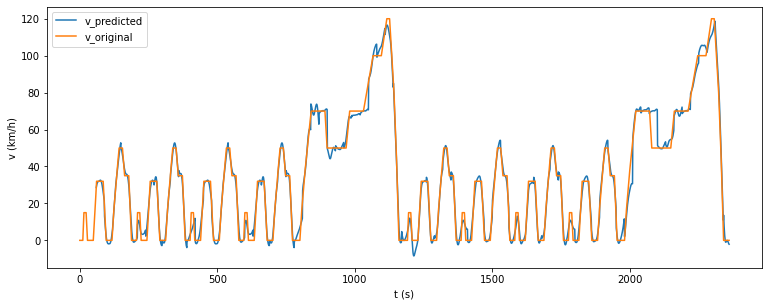

In [105]:
plt.rcParams["figure.figsize"] = (12.8, 4.8)
ax1 = predictions_df.loc[(predictions_df.index >= IN_STEPS) & (predictions_df.index <= 2360)].plot()
ax2 = df_.plot(ax=ax1)
plt.legend(['v_predicted', 'v_original']);
plt.xlabel('t (s)')
plt.ylabel('v (km/h)')
plt.show()

In [112]:
def prepare_to_write_csv(predictions_df, in_steps):
    predictions_df.index.name = 'time'
    predictions_df.columns = ['v']

    predictions_df = predictions_df[:2361]
    
    # Set the lower limit value for the velocity to 0.
    predictions_df = predictions_df.applymap(lambda x: 0 if x < 0 else x)
    # Convert the unit to (m/s).
    predictions_df = predictions_df.applymap(lambda x: x * 1000 / 3600)

    return predictions_df

predictions_df = prepare_to_write_csv(predictions_df, IN_STEPS)
predictions_df.to_csv('data/model_output/pv_lstm-60-30-16-16.csv')

#### LSTM-120-30-16-16

Epoch 1/100
70/70 [==============================] - 5s 75ms/step - loss: 0.7720 - mean_absolute_error: 0.7066 - val_loss: 0.5071 - val_mean_absolute_error: 0.5901
Epoch 2/100
70/70 [==============================] - 4s 62ms/step - loss: 0.4452 - mean_absolute_error: 0.5436 - val_loss: 0.3969 - val_mean_absolute_error: 0.5062
Epoch 3/100
70/70 [==============================] - 4s 61ms/step - loss: 0.3617 - mean_absolute_error: 0.4826 - val_loss: 0.3149 - val_mean_absolute_error: 0.4553
Epoch 4/100
70/70 [==============================] - 4s 61ms/step - loss: 0.2822 - mean_absolute_error: 0.4339 - val_loss: 0.2404 - val_mean_absolute_error: 0.4022
Epoch 5/100
70/70 [==============================] - 4s 56ms/step - loss: 0.2628 - mean_absolute_error: 0.4231 - val_loss: 0.2494 - val_mean_absolute_error: 0.4136
Epoch 6/100
70/70 [==============================] - 4s 54ms/step - loss: 0.2268 - mean_absolute_error: 0.3894 - val_loss: 0.2036 - val_mean_absolute_error: 0.3643
Epoch 7/100
70/7

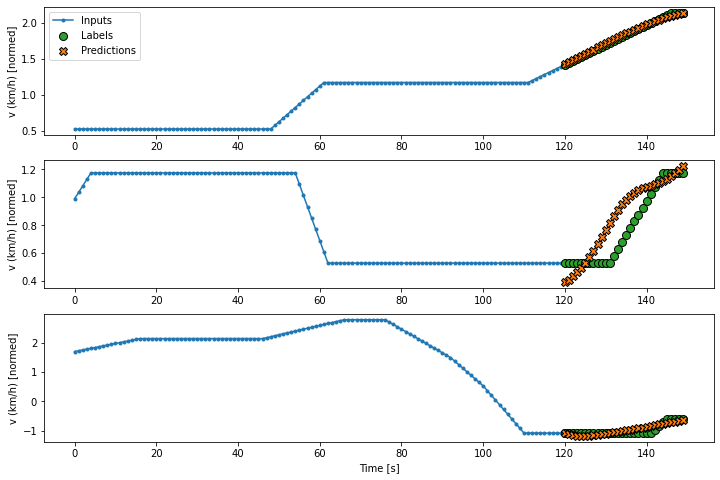

In [113]:
IN_STEPS = 120
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
lstm_120_30_16_16 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

history = compile_and_fit(lstm_120_30_16_16, multi_window)

multi_performance = {'LSTM-120-30-16-16': lstm_120_30_16_16.evaluate(multi_window.train)}

multi_window.plot(lstm_120_30_16_16)
plt.show()

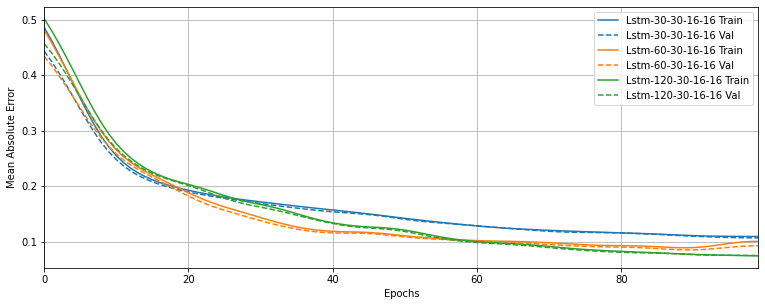

In [114]:
histories['LSTM-120-30-16-16'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

In [115]:
lstm_120_30_16_16.save("models/LSTM/32-100/120-30-16-16")

INFO:tensorflow:Assets written to: models/LSTM/32-100/120-30-16-16\assets


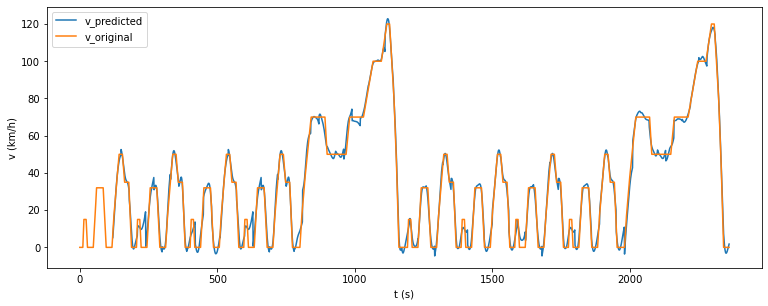

In [116]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=new_data,
    targets=None,
    sequence_length=IN_STEPS,
    sequence_stride=OUT_STEPS,
    shuffle=False,
    batch_size=32)
    
predictions = lstm_120_30_16_16.predict(ds)
predictions = (predictions * df_std[0]) + df_mean[0]

predictions_df = postprocess_predictions(predictions, IN_STEPS)

def compare_to_original_cycle(predictions_df):
    plt.rcParams["figure.figsize"] = (12.8, 4.8)
    ax1 = predictions_df.loc[(predictions_df.index >= IN_STEPS) & (predictions_df.index <= 2360)].plot()
    ax2 = df_.plot(ax=ax1)
    plt.legend(['v_predicted', 'v_original']);
    plt.xlabel('t (s)')
    plt.ylabel('v (km/h)')
    plt.show()

compare_to_original_cycle(predictions_df)

In [117]:
predictions_df = prepare_to_write_csv(predictions_df, IN_STEPS)
predictions_df.to_csv('data/model_output/pv_lstm-120-30-16-16.csv')

#### LSTM-180-30-16-16

Epoch 1/100
68/68 [==============================] - 7s 102ms/step - loss: 0.7945 - mean_absolute_error: 0.7162 - val_loss: 0.5247 - val_mean_absolute_error: 0.5988
Epoch 2/100
68/68 [==============================] - 6s 84ms/step - loss: 0.4635 - mean_absolute_error: 0.5555 - val_loss: 0.4116 - val_mean_absolute_error: 0.5167
Epoch 3/100
68/68 [==============================] - 6s 85ms/step - loss: 0.3856 - mean_absolute_error: 0.4980 - val_loss: 0.3513 - val_mean_absolute_error: 0.4745
Epoch 4/100
68/68 [==============================] - 6s 84ms/step - loss: 0.3142 - mean_absolute_error: 0.4454 - val_loss: 0.2534 - val_mean_absolute_error: 0.4053
Epoch 5/100
68/68 [==============================] - 6s 84ms/step - loss: 0.2198 - mean_absolute_error: 0.3770 - val_loss: 0.1919 - val_mean_absolute_error: 0.3487
Epoch 6/100
68/68 [==============================] - 6s 86ms/step - loss: 0.1815 - mean_absolute_error: 0.3331 - val_loss: 0.1654 - val_mean_absolute_error: 0.3178
Epoch 7/100
68/

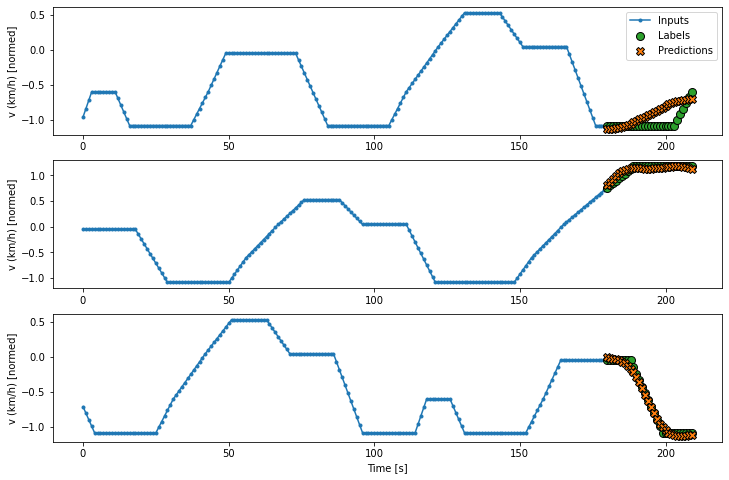

In [118]:
IN_STEPS = 180
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
lstm_180_30_16_16 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

history = compile_and_fit(lstm_180_30_16_16, multi_window)

multi_performance = {'LSTM-180-30-16-16': lstm_180_30_16_16.evaluate(multi_window.train)}

multi_window.plot(lstm_180_30_16_16)
plt.show()

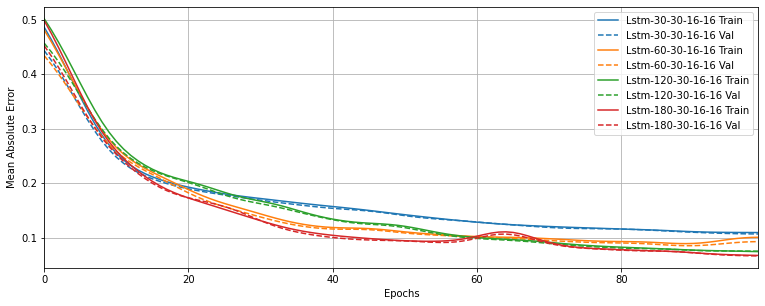

In [119]:
histories['LSTM-180-30-16-16'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

In [123]:
lstm_180_30_16_16.save("models/LSTM/32-100/180-30-16-16")

INFO:tensorflow:Assets written to: models/LSTM/32-100/180-30-16-16\assets


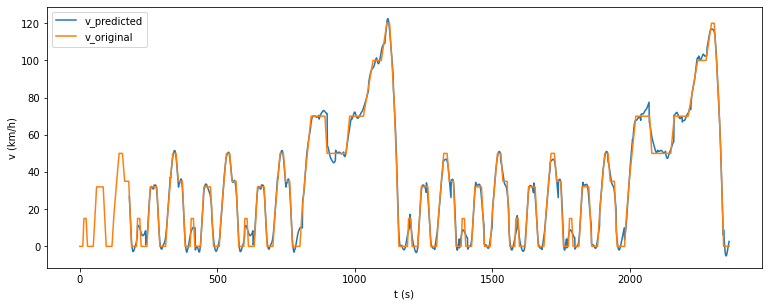

In [124]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=new_data,
    targets=None,
    sequence_length=IN_STEPS,
    sequence_stride=OUT_STEPS,
    shuffle=False,
    batch_size=32)
    
predictions = lstm_180_30_16_16.predict(ds)
predictions = (predictions * df_std[0]) + df_mean[0]

predictions_df = postprocess_predictions(predictions, IN_STEPS)

compare_to_original_cycle(predictions_df)

In [125]:
predictions_df = prepare_to_write_csv(predictions_df, IN_STEPS)
predictions_df.to_csv('data/model_output/pv_lstm-180-30-16-16.csv')

#### LSTM-300-30-16-16

Epoch 1/100
64/64 [==============================] - 10s 151ms/step - loss: 0.8177 - mean_absolute_error: 0.7289 - val_loss: 0.5443 - val_mean_absolute_error: 0.6094
Epoch 2/100
64/64 [==============================] - 9s 133ms/step - loss: 0.4588 - mean_absolute_error: 0.5487 - val_loss: 0.3952 - val_mean_absolute_error: 0.5031
Epoch 3/100
64/64 [==============================] - 9s 135ms/step - loss: 0.3511 - mean_absolute_error: 0.4681 - val_loss: 0.3171 - val_mean_absolute_error: 0.4443
Epoch 4/100
64/64 [==============================] - 9s 136ms/step - loss: 0.2905 - mean_absolute_error: 0.4169 - val_loss: 0.2818 - val_mean_absolute_error: 0.4176
Epoch 5/100
64/64 [==============================] - 9s 135ms/step - loss: 0.2408 - mean_absolute_error: 0.3762 - val_loss: 0.2123 - val_mean_absolute_error: 0.3531
Epoch 6/100
64/64 [==============================] - 9s 134ms/step - loss: 0.1896 - mean_absolute_error: 0.3329 - val_loss: 0.1727 - val_mean_absolute_error: 0.3182
Epoch 7/1

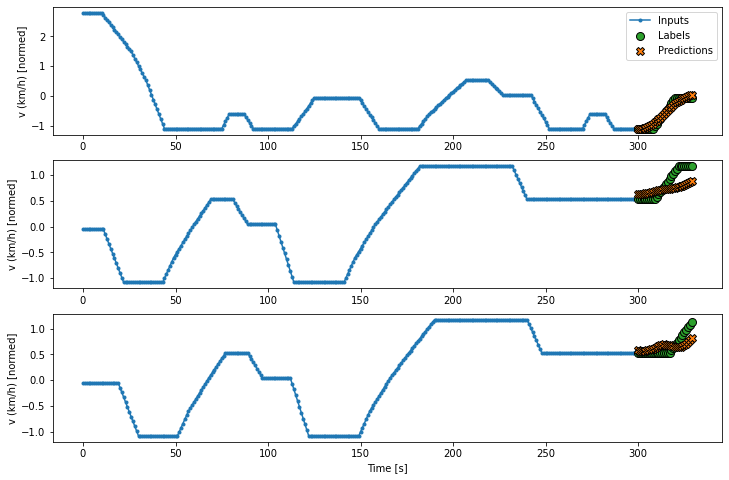

In [127]:
IN_STEPS = 300
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
lstm_300_30_16_16 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

history = compile_and_fit(lstm_300_30_16_16, multi_window)

multi_performance = {'LSTM-300-30-16-16': lstm_300_30_16_16.evaluate(multi_window.train)}

multi_window.plot(lstm_300_30_16_16)
plt.show()

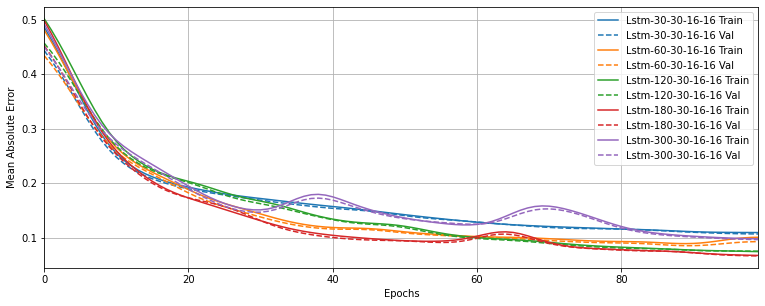

In [128]:
histories['LSTM-300-30-16-16'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(histories)

In [129]:
lstm_300_30_16_16.save("models/LSTM/32-100/300-30-16-16")

INFO:tensorflow:Assets written to: models/LSTM/32-100/300-30-16-16\assets


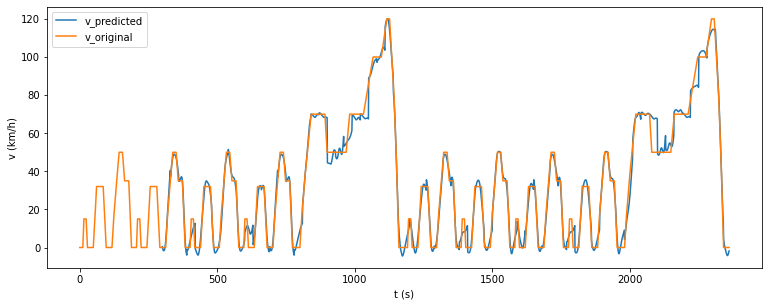

In [130]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=new_data,
    targets=None,
    sequence_length=IN_STEPS,
    sequence_stride=OUT_STEPS,
    shuffle=False,
    batch_size=32)
    
predictions = lstm_300_30_16_16.predict(ds)
predictions = (predictions * df_std[0]) + df_mean[0]

predictions_df = postprocess_predictions(predictions, IN_STEPS)

compare_to_original_cycle(predictions_df)

In [131]:
predictions_df = prepare_to_write_csv(predictions_df, IN_STEPS)
predictions_df.to_csv('data/model_output/pv_lstm-300-30-16-16.csv')

In [133]:
x = np.arange(len(multi_performance))

multi_performance['LSTM-30-30-16-16'] = multi_lstm_model.evaluate(multi_window.train)
multi_performance['LSTM-60-30-16-16'] = lstm_60_30_16_16.evaluate(multi_window.train)
multi_performance['LSTM-120-30-16-16'] = lstm_120_30_16_16.evaluate(multi_window.train)
multi_performance['LSTM-180-30-16-16'] = lstm_180_30_16_16.evaluate(multi_window.train)
multi_performance['LSTM-300-30-16-16'] = lstm_300_30_16_16.evaluate(multi_window.train)

width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')

multi_performance

64/64 [==============================] - 1s 22ms/step - loss: 0.0251 - mean_absolute_error: 0.0937


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [v (km/h), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

#### LSTM-600-30-16-16

In [ ]:
IN_STEPS = 600
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# RNN
lstm_600_30_16_16 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])])

history = compile_and_fit(lstm_600_30_16_16, multi_window)

multi_performance = {'LSTM-600-30-16-16': lstm_300_30_16_16.evaluate(multi_window.train)}

multi_window.plot(lstm_300_30_16_16)
plt.show()

#### Plot SoC the result

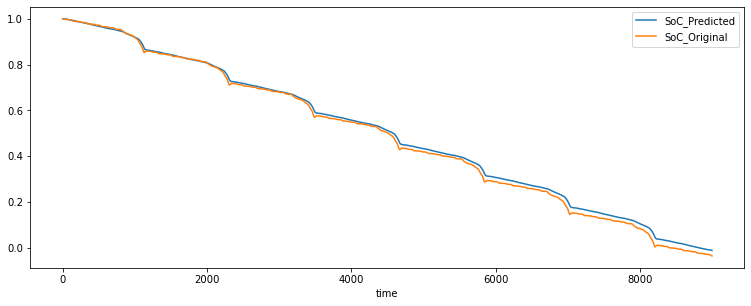

In [18]:
soc_p_df = pd.read_csv('prediction_soc.csv', index_col='time')
soc_df = pd.read_csv('soc.csv', index_col='time')

# soc_p_df.plot(figsize=(12.8,4.8), label='SoC')
# soc_df.plot(figsize=(12.8,4.8), label='SoC')

plt.rcParams["figure.figsize"] = (12.8, 4.8)
ax1 = soc_p_df.plot(y='Soc', label='SoC_Predicted')
ax2 = soc_df.plot(y='Soc', label='SoC_Original', ax=ax1)
plt.xlabel('time')
plt.show()